# Построение ML-продукта для предсказания следующего заказа пользователя

- **Описание**
<br>Сервисы доставки еды уже давно перестали быть просто курьерами, которые привозят заказ. Индустрия e-grocery стремительно идет к аккумулированию и использованию больших данных, чтобы знать о своих пользователях больше и предоставлять более качественные и персонализированные услуги. Одним из шагов к такой персонализации может быть разработка модели, которая понимает привычки и нужды пользователя, и, к примеру, может угадать, что и когда пользователь захочет заказать в следующий раз.

Такая модель, будучи разработанной, может принести значительную ценность для клиента - сэкономить время при сборке корзины, помочь ничего не забыть в заказе, убрать необходимость планировать закупки и следить за заканчивающимися запасами продуктов.

В данном соревновании участникам предлагается решить задачу предсказания следующего заказа пользователя (безотносительно конкретного момента времени, когда этот заказ произойдет). Заказ пользователя состоит из списка уникальных категорий товаров, вне зависимости от того, сколько продуктов каждой категории он взял.

- **Метрика Заказчика: F1-score**

- **Описание данных**
<br>В качестве тренировочных данных представляется датасет с историей заказов 20000 пользователей вплоть до даты отсечки, которая разделяет тренировочные и тестовые данные по времени.

train.csv:
- user_id - уникальный id пользователя
- order_completed_at - дата заказа
- cart - список уникальных категорий (category_id), из которых состоял заказ
<br>В качестве прогноза необходимо для каждой пары пользователь-категория из примера сабмита вернуть 1, если категория будет присутствовать в следующем заказе пользователя, или 0 в ином случае. Список категорий для каждого пользователя примере сабмита - это все категории, которые он когда-либо заказывал.

sample_submission.csv:
Пример сабмита. В тест входят не все пользователи из тренировочных данных, так как некоторые из них так ничего и не заказали после даты отсечки.

- id - идентификатор строки - состоит из user_id и category_id, разделенных точкой с запятой: f'{user_id};{category_id}'. Из-за особенностей проверяющей системы Kaggle InClass, использовать колонки user_id, category_id в качестве индекса отдельно невозможно
- target - 1 или 0 - будет ли данная категория присутствовать в следующем заказе пользователя

<br>План
- знакомство с данными
- чистка, первичная обработка
- исследовательский анализ данных
- разделение на выборки
- обучение моделей
- выбор лучшей модели
- тестирование моделей (тестовая выборка - 1 год)
- построение прогноза (период выбран годовой, с удалением повторных входов id)

## Настройка рабочей среды

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet
from sklearn.metrics import f1_score
from kaggle_secrets import UserSecretsClient
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from statsmodels.tsa.seasonal import seasonal_decompose
# from sklearn.model_selection import GridSearchCV, TimeSeriesSplit

Установка констант

In [2]:
RANDOM_STATE=42
PRED = 30  # PRED = 120

## Загрузка и первичный EDA

In [3]:
try:
    df = pd.read_csv(UserSecretsClient().get_secret("train_path"), parse_dates=['order_completed_at'])
    sample_sub = pd.read_csv(UserSecretsClient().get_secret("sample_submission_path"))
    print('загружено из каталога Kaggle')
except:
    df = pd.read_csv('data/train.csv')
    sample_sub = pd.read_csv('data/sample_submission.csv')
    print('загружено из каталога "data"')

загружено из каталога Kaggle


### Импорт выходных и праздничных дней
<br>Загружено с сайта [xmlcalendar](https://xmlcalendar.ru/)

In [4]:
years = [2015, 2016, 2017, 2018, 2019, 2020]
holidays_dict = {}

for year in years:
    url = f"https://xmlcalendar.ru/data/ru/{year}/calendar.csv"
    holidays_dict[f'{year}'] = pd.read_csv(url)
print('данные успешно загружены')

данные успешно загружены


In [5]:
def date_preparation(data, year):
    '''
    - на вход принимает датасет с праздниками и год этого датасета
    - возвращает обработанный датасет
    '''
    data = data.reset_index(drop=True).T[:13]
    data = data.set_axis(data.iloc[0], axis=1)[1:]
    data.insert(0, 'month', range(1, len(data) + 1))
    data.insert(0, 'year', year)
    data = data.replace(['\+', '\*'], '', regex=True)
    data[year] = data[year].str.split(',')
    data = data.explode(year)
    data = data.rename(columns={year: 'day'})
    data['date'] = pd.to_datetime(data[['year', 'month', 'day']])
    
    return data

In [6]:
holidays = pd.DataFrame()

for year, year_str in zip(years, holidays_dict.keys()):
    holidays_year = date_preparation(holidays_dict[year_str], year)
    holidays = pd.concat([holidays, holidays_year], ignore_index=True)

holidays.sample(5)

Год/Месяц,year,month,day,date
315,2017,7,22,2017-07-22
753,2020,11,29,2020-11-29
685,2020,5,7,2020-05-07
654,2020,4,6,2020-04-06
590,2019,10,20,2019-10-20


### Исследование основного датафрейма

In [7]:
df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3123064 entries, 0 to 3123063
Data columns (total 3 columns):
 #   Column              Dtype         
---  ------              -----         
 0   user_id             int64         
 1   order_completed_at  datetime64[ns]
 2   cart                int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 71.5 MB


,user_id,order_completed_at,cart
984433,3813,2020-03-13 12:51:36,57
1751985,4944,2020-06-04 01:55:21,22
1967361,15331,2020-06-18 10:22:03,57
1415474,1942,2020-05-05 17:13:55,10
122129,1519,2019-08-04 18:20:16,87


In [8]:
print(f"количество полных дубликатов строк: {df.duplicated().sum()}")

количество полных дубликатов строк: 0


In [9]:
print(f"начальная дата наблюдений: {df['order_completed_at'].min()}")
print(f"конечная дата наблюдений: {df['order_completed_at'].max()}")

начальная дата наблюдений: 2015-03-22 09:25:46
конечная дата наблюдений: 2020-09-03 23:45:45


In [10]:
sample_sub.info()
display(sample_sub.head())
print(f"количество уникальных сочетаний id: {sample_sub['id'].nunique()}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 790449 entries, 0 to 790448
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      790449 non-null  object
 1   target  790449 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 12.1+ MB


,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


количество уникальных сочетаний id: 790449


In [11]:
df[(df['user_id'] == 2) & (df['cart'] == 57)]

,user_id,order_completed_at,cart
14,2,2015-03-22 09:25:46,57
97,2,2016-05-27 19:21:46,57
10697,2,2018-01-12 23:36:19,57
222784,2,2019-10-03 17:37:23,57
246982,2,2019-10-11 09:05:20,57
307939,2,2019-10-25 21:05:56,57
345177,2,2019-11-02 22:00:26,57
382037,2,2019-11-09 20:45:19,57
404912,2,2019-11-13 19:05:45,57
599000,2,2019-12-22 14:57:39,57


### Выводы и наблюдения
- полных дубликатов строк не обнаружено
- данные предоставлены за пять лет: с 22.03.2015 до 03.09.2020
- в датафрейме `sample_sub` представлены `id` пользователей с `id` товаров и целевой признак
- количество уникальных сочетаний id - 790449

## Предобработка данных

Кумулятивная сумма покупок по клиенту за 120 дней

In [12]:
df['client_cum_sum_120'] = 0
prev_client_id = None
prev_purchase_date = None
client_cum_sum_120 = 0

for index, row in df.iterrows():
    if (prev_client_id == row['user_id'] 
        and (row['order_completed_at'] - prev_purchase_date).days <= 120):
        client_cum_sum_120 += 1
    else:
        client_cum_sum_120 = 1

    df.at[index, 'client_cum_sum_120'] = client_cum_sum_120

    prev_client_id = row['user_id']
    prev_purchase_date = row['order_completed_at']
df.sample(5)

,user_id,order_completed_at,cart,client_cum_sum_120
2227576,16782,2020-07-06 12:07:04,420,8
1411380,4462,2020-05-05 11:18:29,57,7
526975,346,2019-12-07 07:50:07,414,20
1928460,5199,2020-06-16 12:02:26,403,17
510070,3092,2019-12-03 16:07:32,26,23


Объединение `id` клиента и `id` категории

In [13]:
df_w = df.copy()
df_w['id'] = df['user_id'].astype(str) + ';' + df['cart'].astype(str)
df_w.drop(['user_id', 'cart'], axis=1, inplace=True)
df_w.sort_values(by='order_completed_at', ascending=True, inplace=True)
df_w.head()

,order_completed_at,client_cum_sum_120,id
0,2015-03-22 09:25:46,1,2;399
15,2015-03-22 09:25:46,16,2;425
14,2015-03-22 09:25:46,15,2;57
13,2015-03-22 09:25:46,14,2;89
11,2015-03-22 09:25:46,12,2;84


In [14]:
print(f"""количество уникальных сочетаний id за последние 120 дней:
{df_w[df_w['order_completed_at'] >= 
(df_w['order_completed_at'].max() - pd.DateOffset(days=PRED))]['id'].nunique()}""")

количество уникальных сочетаний id за последние 120 дней:
321361


Создание целевого признака

In [15]:
df_w['target'] = 0

last_occurrence = {}

for index, row in df_w.iterrows():
    id_value = row['id']
    if id_value in last_occurrence:
        df_w.at[last_occurrence[id_value], 'target'] = 1
    last_occurrence[id_value] = index
    
df_w.to_csv('ready_data.csv', index=False)
print('target создан, датафрейм сохранён')

target создан, датафрейм сохранён


Загрузка датафрейма с таргетом

In [16]:
# try:
#     df_w = pd.read_csv('data/ready_data.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога "data"')
# except:
#     df_w = pd.read_csv('/kaggle/working/ready_data.csv', parse_dates=['order_completed_at'])
#     print('загружено из каталога Kaggle')
# finally:
#     print(df_w.shape)

Проверка корректности созданного target

In [17]:
df_w[df_w['id'] == '2;57']

,order_completed_at,client_cum_sum_120,id,target
14,2015-03-22 09:25:46,15,2;57,1
97,2016-05-27 19:21:46,5,2;57,1
10697,2018-01-12 23:36:19,13,2;57,1
222784,2019-10-03 17:37:23,22,2;57,1
246982,2019-10-11 09:05:20,22,2;57,1
307939,2019-10-25 21:05:56,1,2;57,1
345177,2019-11-02 22:00:26,9,2;57,1
382037,2019-11-09 20:45:19,10,2;57,1
404912,2019-11-13 19:05:45,3,2;57,1
599000,2019-12-22 14:57:39,4,2;57,0


Добавление признака `is_holiday`

In [18]:
df_w['date'] = df_w['order_completed_at'].apply(lambda x: x.strftime('%Y-%m-%d'))
df_w['date'] = pd.to_datetime(df_w['date'])
df_w['target'] = df_w['target'].astype('int8')
df_w['is_holiday'] = df_w['date'].isin(holidays['date']).astype('int8')
df_w.drop('date', axis=1, inplace=True)

Кумулятивная сумма за 120 дней по сочетанию `user_id` + `cart`

In [19]:
# нет смысла
# id_cum_sum_120
# 1    3123037
# 2         27
# Name: count, dtype: int64

# df_w['id_cum_sum_120'] = 0
# prev_id = None
# prev_date = None
# id_cum_sum_120 = 0

# for index, row in df_w.iterrows():
#     if (prev_id == row['id'] 
#         and (row['order_completed_at'] - prev_date).days <= 120):
#         id_cum_sum_120 += 1
#     else:
#         id_cum_sum_120 = 1

#     df_w.at[index, 'id_cum_sum_120'] = id_cum_sum_120

#     prev_id = row['id']
#     prev_date = row['order_completed_at']
# df_w.sample(5)

Установка даты индексом

In [20]:
df_w.set_index('order_completed_at', inplace=True)
df_w.sort_index(inplace=True)

Соотношение классов целевого признака

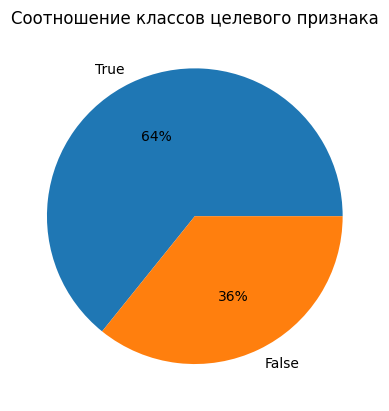

In [21]:
sizes = [df_w['target'].value_counts()[1], df_w['target'].value_counts()[0]]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=['True', 'False'], autopct='%1.0f%%')
plt.title('Соотношение классов целевого признака', size=12)
plt.show()

### Выводы и наблюдения
- добавлен признак `client_cum_sum_120` кумулятивной суммы 
  <br>активностей клиента в течение 120-ти дней
- объединены `user_id` клиента и `cart` категории товаров в один признак `id`
- создан целевой признак `target`
- создан признак `is_holiday`
- добавлен признак `id_cum_sum_120` кумулятивной суммы 
  <br>активностей сочетания `client_id` + `cart` в течение 120-ти дней
- дата установлена в качестве индекса
- изучен баланс классов целевого признака

## Проверка наличия сезонности

In [22]:
df_s = df_w.copy()
# df_s.set_index('order_completed_at', inplace=True)
# df_s.sort_index(inplace=True)

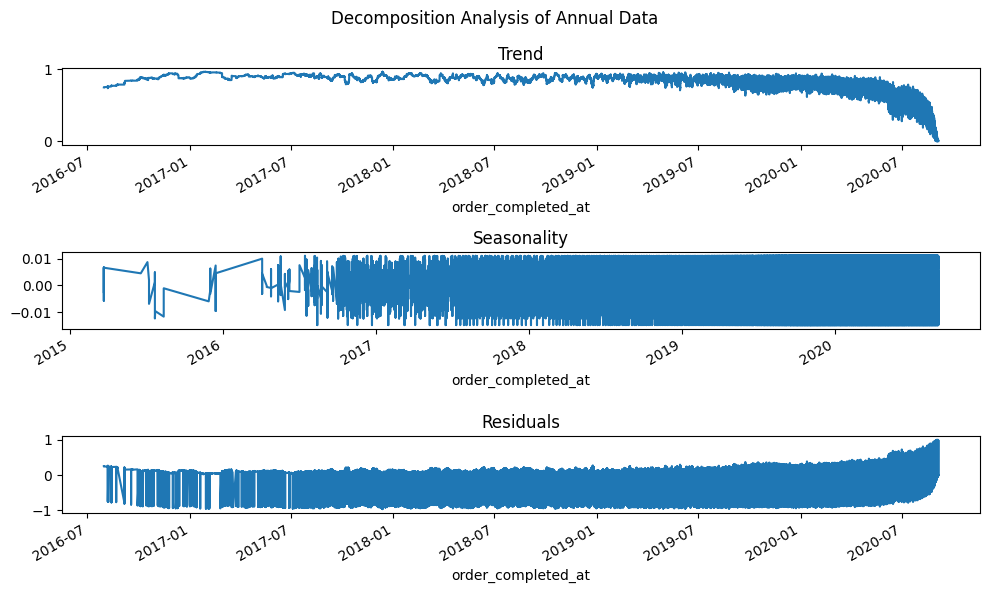

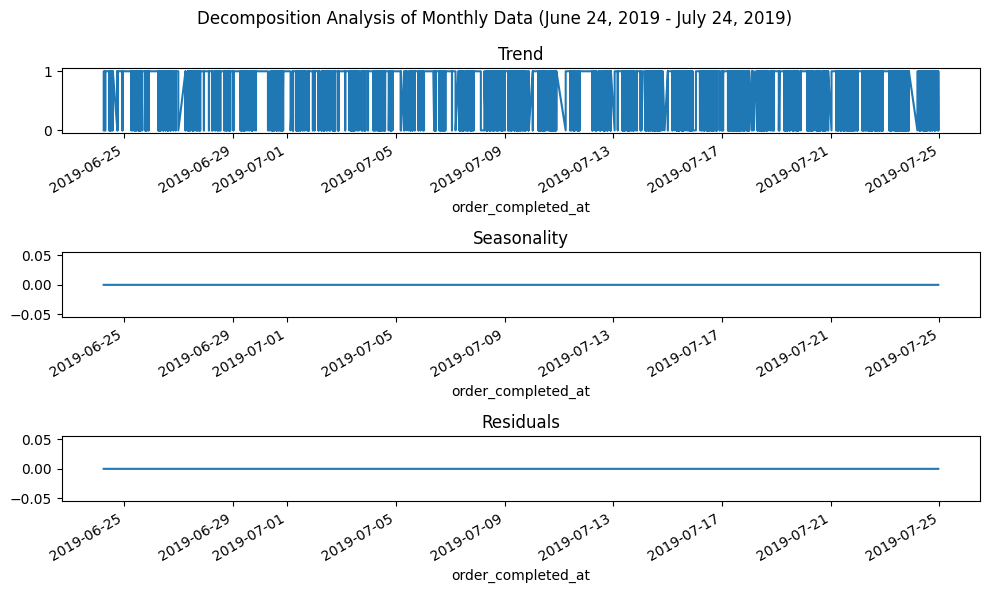

In [23]:
'''разложение на тренд, сезонность и остатки за год'''

decomposed_units_year = seasonal_decompose(df_s['target'], period=365)

plt.figure(figsize=(10,6))
plt.suptitle('Decomposition Analysis of Annual Data', fontsize=12)
plt.subplot(311)
decomposed_units_year.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units_year.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units_year.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

'''разложение на тренд, сезонность и остатки за две недели'''

decomposed_units_month = seasonal_decompose(df_s['target']['2019-06-24':'2019-07-24'], period=1)

plt.figure(figsize=(10,6))
plt.suptitle('Decomposition Analysis of Monthly Data (June 24, 2019 - July 24, 2019)', fontsize=12)
plt.subplot(311)
decomposed_units_month.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed_units_month.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed_units_month.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### Выводы и наблюдения
- сезонности не обнаружено;
- общего тренда также нет

## Подготовка к обучению

Разделение на `train` и `test`

In [24]:
df_w.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3123064 entries, 2015-03-22 09:25:46 to 2020-09-03 23:45:45
Data columns (total 4 columns):
 #   Column              Dtype 
---  ------              ----- 
 0   client_cum_sum_120  int64 
 1   id                  object
 2   target              int8  
 3   is_holiday          int8  
dtypes: int64(1), int8(2), object(1)
memory usage: 109.7+ MB


In [25]:
y = df_w['target']
X = df_w.drop(['target'], axis=1)

X_train = X[X.index < (X.index.max() - pd.DateOffset(days=PRED))]
X_test = X[X.index >= (X.index.max() - pd.DateOffset(days=PRED))]
y_train = y[:X_train.shape[0]]
y_test = y[X_train.shape[0]:]
X_train.shape, X_test.shape, y_train.shape, y_test.shape
# ((1431604, 3), (1691460, 3), (1431604,), (1691460,)) PRED = 120
# ((2677986, 3), (445078, 3), (2677986,), (445078,)) PRED = 30

((2677986, 3), (445078, 3), (2677986,), (445078,))

Масштабирование данных

In [26]:
scaler = StandardScaler()
X_train_scl = (pd.DataFrame(scaler.fit_transform(X_train.drop(['id'], axis=1)),
                            columns=X_train.drop(['id'], axis=1).columns,
                            index=X_train.drop(['id'], axis=1).index))
X_train_scl = pd.concat([X_train_scl, X_train[['id']]], axis=1)
X_test_scl = (pd.DataFrame(scaler.transform(X_test.drop(['id'], axis=1)),
                           columns=X_test.drop(['id'], axis=1).columns,
                           index=X_test.drop(['id'], axis=1).index))
X_test_scl = pd.concat([X_test_scl, X_test[['id']]], axis=1)

X_train_scl.shape, X_test_scl.shape

((2677986, 3), (445078, 3))

## Обучение модели

Baseline - LogisticRegression
<br>Предсказания на обучающей выборке

In [27]:
baseline = LogisticRegression(random_state=RANDOM_STATE, class_weight='balanced')
baseline.fit(X_train_scl.drop(['id'], axis=1), y_train)
baseline_pred = baseline.predict(X_train_scl.drop(['id'], axis=1))
baseline_f1 = f1_score(y_train, baseline_pred)
baseline_f1

0.5428023414824554

Предсказания на тестовой выборке

In [28]:
baseline_test_pred = baseline.predict(X_test_scl.drop(['id'], axis=1))
baseline_test_f1 = f1_score(y_test, baseline_test_pred)
baseline_test_f1

0.29329753644287304

In [29]:
X_test_pr = X_test_scl.copy()
X_test_pr['baseline'] = baseline_test_pred
X_test_pr['target'] = y_test.values
X_test_pr.tail()
# X_test_pr['predictions'].sum(), X_test_pr['target'].sum()

,client_cum_sum_120,is_holiday,id,baseline,target
order_completed_at,,,,,
2020-09-03 23:45:45,-0.904170,-0.835578,12702;54,0,0
2020-09-03 23:45:45,-1.141573,-0.835578,12702;382,0,0
2020-09-03 23:45:45,2.182074,-0.835578,12702;24,1,0
2020-09-03 23:45:45,0.401549,-0.835578,12702;376,0,0
2020-09-03 23:45:45,2.300775,-0.835578,12702;430,1,0


Случайный лес
<br>Предсказания на обучающей выборке

In [30]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
rfc.fit(X_train_scl.drop(['id'], axis=1), y_train)
rfc_pred = rfc.predict(X_train_scl.drop(['id'], axis=1))
rfc_f1 = f1_score(y_train, rfc_pred)
rfc_f1

0.6088234604384228

Предсказания на тестовой выборке

In [31]:
rfc_test_pred = rfc.predict(X_test_scl.drop(['id'], axis=1))
rfc_test_f1 = f1_score(y_test, rfc_test_pred)
rfc_test_f1

0.3271070735696266

In [32]:
X_test_pr['rfc'] = rfc_test_pred
display(X_test_pr.tail())
X_test_pr['baseline'].sum(), X_test_pr['target'].sum(), X_test_pr['rfc'].sum()

,client_cum_sum_120,is_holiday,id,baseline,target,rfc
order_completed_at,,,,,,
2020-09-03 23:45:45,-0.904170,-0.835578,12702;54,0,0,0
2020-09-03 23:45:45,-1.141573,-0.835578,12702;382,0,0,0
2020-09-03 23:45:45,2.182074,-0.835578,12702;24,1,0,1
2020-09-03 23:45:45,0.401549,-0.835578,12702;376,0,0,1
2020-09-03 23:45:45,2.300775,-0.835578,12702;430,1,0,1


(140738, 123717, 178337)

## Обучение на полном наборе данных и получение предсказаний покупок

Добавление рандомной даты

In [33]:
sample_sub['date'] = pd.to_datetime('2020-03-31')
sample_sub.drop(['target'], axis=1, inplace=True)

Добавление признака `is_holiday`

In [34]:
sample_sub['is_holiday'] = sample_sub['date'].isin(holidays['date']).astype('int8')

Удаление всех записей, кроме самых последних `id`

In [35]:
df_unique_last = X.drop_duplicates(subset='id', keep='last')
sample_sub = sample_sub.merge(df_unique_last[['id', 'client_cum_sum_120']], how='left', on='id')
sample_sub.set_index('date', inplace=True)
sample_sub.sort_index(inplace=True)

Масштабирование данных

In [36]:
X_scl = (pd.DataFrame(scaler.fit_transform(X.drop(['id'], axis=1)),
                      columns=X.drop(['id'], axis=1).columns,
                      index=X.drop(['id'], axis=1).index))
X_scl = pd.concat([X_scl, X['id']], axis=1)
X_sub_scl = (pd.DataFrame(scaler.transform(sample_sub[['client_cum_sum_120', 'is_holiday']]),
                          columns=sample_sub[['client_cum_sum_120', 'is_holiday']].columns,
                          index=sample_sub[['client_cum_sum_120', 'is_holiday']].index))
X_sub_scl = pd.concat([X_sub_scl, sample_sub['id']], axis=1)

X_scl.shape, X_sub_scl.shape

((3123064, 3), (790449, 3))

Обучение модели

In [37]:
rfc = RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced')
rfc.fit(X_scl.drop(['id'], axis=1), y)
rfc_pred_big = rfc.predict(X_scl.drop(['id'], axis=1))
rfc_big_f1 = f1_score(y, rfc_pred_big)
rfc_big_f1

0.5641479504889368

Предсказания для отправки

In [38]:
X_sub_scl

,client_cum_sum_120,is_holiday,id
date,,,
2020-03-31,-1.139846,1.264448,0;133
2020-03-31,-1.019773,1.264448,0;5
2020-03-31,-0.779627,1.264448,0;10
2020-03-31,1.381688,1.264448,0;396
2020-03-31,-0.539481,1.264448,0;14
...,...,...,...
2020-03-31,-0.419408,1.264448,19998;26
2020-03-31,-0.539481,1.264448,19998;31
2020-03-31,-0.299335,1.264448,19998;29


In [39]:
rfc_sub_pred = rfc.predict(X_sub_scl.drop(['id'], axis=1))
submission = X_sub_scl.copy()
submission['target'] = rfc_sub_pred

In [40]:
submission.drop(['client_cum_sum_120', 'is_holiday'], axis=1, inplace=True)
submission.reset_index(drop=True, inplace=True)
submission.head()

,id,target
0,0;133,1
1,0;5,1
2,0;10,1
3,0;396,1
4,0;14,1


In [41]:
submission.to_csv('submission.csv', index=False)
print('submission.csv сохранён')

submission.csv сохранён
